<a href="https://colab.research.google.com/github/orlandxrf/curso-dl/blob/main/notebooks/10d_FineTuning_SentimentAnalysis_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning Análisis de Sentimientos
Dado el conjunto de datos se desarrollará una red densa para clasificar sentimientos

In [27]:
# establecer parametros para almacenar y cargar el conjunto de datos del repositorio de Github
import os

URL = 'https://github.com/orlandxrf/curso-dl/blob/main/data/IMDB.zip?raw=True'
data_folder = 'data'
filepath = os.path.join(data_folder, 'IMDB.zip')

## Obtener el conjunto de datos

In [28]:
# crear carpeta para almacenar el conjunto de datos
! mkdir {data_folder}
# descargar conjunto de datos y alamcenar
! wget -nc {URL} -O {filepath}

mkdir: cannot create directory ‘data’: File exists
File ‘data/IMDB.zip’ already there; not retrieving.


In [29]:
# comprobrar
! ls -lh data/*


-rw-r--r-- 1 root root 26M Apr 19 16:40 data/IMDB.zip


## Analizar conjunto de datos

In [30]:
import pandas as pd

# df = pd.read_csv('data/IMDB.zip')
df = pd.read_csv('data/IMDB.zip', compression='zip', header=0, sep=',', quotechar='"')

# eliminar columnas 'tweet_id' y 'author'
# df.drop('tweet_id',axis=1,inplace=True)
# df.drop('author',axis=1,inplace=True)
print (df.head(10))
print (f"\nLongitud de tweets: {len(df):,}")

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
5  Probably my all-time favorite movie, a story o...  positive
6  I sure would like to see a resurrection of a u...  positive
7  This show was an amazing, fresh & innovative i...  negative
8  Encouraged by the positive comments about this...  negative
9  If you like original gut wrenching laughter yo...  positive

Longitud de tweets: 50,000


1	25000	positive
2	25000	negative

50,000 tweets


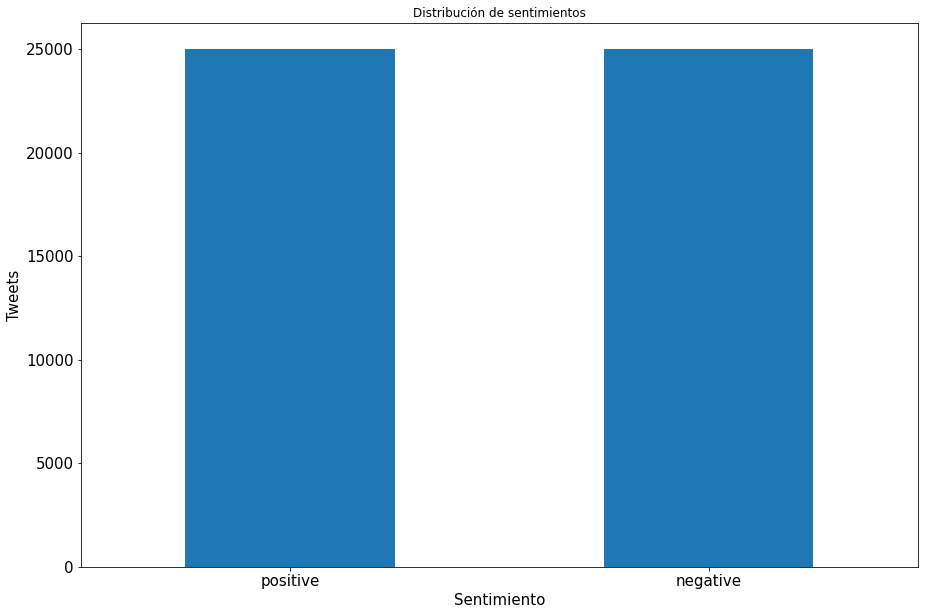

In [31]:
import matplotlib.pyplot as plt

sentiments = dict(pd.value_counts(df['sentiment']))
classes = list(sentiments.keys())
for i, sent in enumerate(sentiments):
  print (f"{i+1}\t{sentiments[sent]}\t{sent}")
print (f"\n{len(df):,} tweets")

# Graficar la distribución
plt.figure(figsize=(15, 10))
pd.value_counts(df['sentiment']).plot.bar(title="Distribución de sentimientos")
plt.xlabel("Sentimiento", fontsize="15")
plt.ylabel("Tweets", fontsize="15")
plt.xticks(rotation=0, fontsize="15")
plt.yticks(fontsize="15")
plt.show()

## Preprocesamiento y división de los datos


In [32]:
def convert_label(tag):
    return 0 if tag == "negative" else 1

df["sentiment"] = df["sentiment"].apply(lambda x: convert_label(x))

print (df.head(10))

                                              review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1
5  Probably my all-time favorite movie, a story o...          1
6  I sure would like to see a resurrection of a u...          1
7  This show was an amazing, fresh & innovative i...          0
8  Encouraged by the positive comments about this...          0
9  If you like original gut wrenching laughter yo...          1


1	25000	1
2	25000	0

50,000 tweets


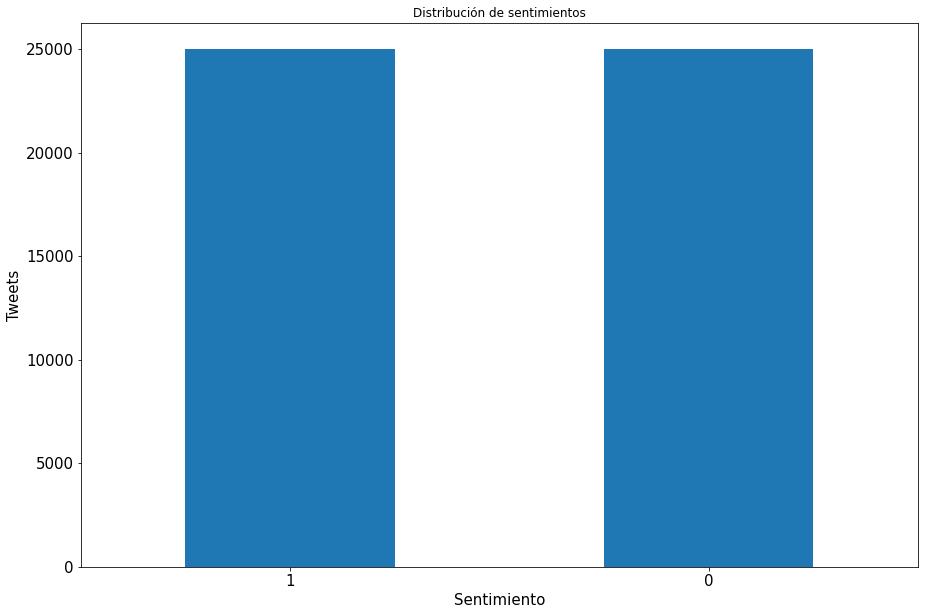

In [33]:
sentiments = dict(pd.value_counts(df['sentiment']))
classes = list(sentiments.keys())
for i, sent in enumerate(sentiments):
  print (f"{i+1}\t{sentiments[sent]}\t{sent}")
print (f"\n{len(df):,} tweets")

# Graficar la distribución
plt.figure(figsize=(15, 10))
pd.value_counts(df['sentiment']).plot.bar(title="Distribución de sentimientos")
plt.xlabel("Sentimiento", fontsize="15")
plt.ylabel("Tweets", fontsize="15")
plt.xticks(rotation=0, fontsize="15")
plt.yticks(fontsize="15")
plt.show()

In [34]:
# dividir el conjunto de datos
# train_set = df[0:40000]
# valid_set = df[40000:45000]
# test_set  = df[45000:50000]

train_set = df[0:3000]
valid_set = df[3000:3500]
test_set  = df[3500:4000]

In [35]:
train_sent = dict(pd.value_counts(train_set['sentiment']))
valid_sent = dict(pd.value_counts(valid_set['sentiment']))
test_sent = dict(pd.value_counts(test_set['sentiment']))

clases = list(train_sent.keys())

print (f">>> Train set")
for i, sent in enumerate(train_sent):
  print (f"{i+1}\t{train_sent[sent]:,}\t{sent}")
print (f"\n{len(train_set):,} tweets\n\n")

print (f">>> Valid set")
for i, sent in enumerate(valid_sent):
  print (f"{i+1}\t{valid_sent[sent]:,}\t{sent}")
print (f"\n{len(valid_set):,} tweets\n\n")

print (f">>> Test set")
for i, sent in enumerate(test_sent):
  print (f"{i+1}\t{test_sent[sent]:,}\t{sent}")
print (f"\n{len(test_set):,} tweets\n\n")




>>> Train set
1	1,508	1
2	1,492	0

3,000 tweets


>>> Valid set
1	255	0
2	245	1

500 tweets


>>> Test set
1	280	0
2	220	1

500 tweets




## Crear clase para el conjunto de datos

In [36]:
! pip install transformers

In [37]:
import torch
from transformers import AutoTokenizer

In [38]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print (device)

cuda:0


In [39]:
class MakeDataset(torch.utils.data.Dataset):

    def __init__(self, reviews, sentiments, tokenizer):
        self.reviews    = reviews # columna donde se encuentra el texto
        self.sentiments = sentiments # columna de la clase (0 o 1)
        self.tokenizer  = tokenizer # tokenizador de los transformers
        self.max_len    = tokenizer.model_max_length # longitud máxima (512 para el modelo BERT)
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, index):
        review = str(self.reviews[index]) # obtener texto por índice
        sentiments = self.sentiments[index] # obtener clase por índice

        # codificar (tokenizar) conjunto de datos usando función: encode_plus()
        encoded_review = self.tokenizer.encode_plus(
            review,
            add_special_tokens    = True,
            max_length            = self.max_len,
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors        = "pt",
            padding               = "max_length",
            truncation            = True
        )

        return {
            'input_ids': encoded_review['input_ids'][0],
            'attention_mask': encoded_review['attention_mask'][0],
            'labels': torch.tensor(sentiments, dtype=torch.long)
        }

In [40]:
# cargar tokenizador del modelo BERT de HuggingFace
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

### Crear objetos MakeDataset para train y valid set

In [41]:
# Create Dataset objects for train/validation sets.
train_set_dataset = MakeDataset(
    reviews    = train_set.review.tolist(),
    sentiments = train_set.sentiment.tolist(),
    tokenizer  = tokenizer,
)

valid_set_dataset = MakeDataset(
    reviews    = valid_set.review.tolist(),
    sentiments = valid_set.sentiment.tolist(),
    tokenizer  = tokenizer,
)

### Crear DataLoader del train y valid set

In [42]:
train_set_dataloader = torch.utils.data.DataLoader(
    train_set_dataset,
    batch_size  = 16,
    num_workers = 4
)

valid_set_dataloader = torch.utils.data.DataLoader(
    valid_set_dataset,
    batch_size  = 16,
    num_workers = 4
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Visualizar un batch

In [43]:
# Get one batch as example.
train_data = next(iter(train_set_dataloader))
valid_data = next(iter(valid_set_dataloader))

# Print the output sizes.
print( train_data["input_ids"].size(), valid_data["input_ids"].size() )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([16, 512]) torch.Size([16, 512])


### Cargar el modelo y realizar Fine-Tuning

In [44]:
from transformers import BertForSequenceClassification

In [45]:
# model_checkpoint = "bert-large-uncased"
model_checkpoint = "distilbert-base-uncased"
model = BertForSequenceClassification.from_pretrained(model_checkpoint)


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Model config BertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dim": 768,
  "dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dim": 3072,
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "n_heads": 12,
  "n_layers": 6,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,


BERT base es un modelo de 24 capas con parámetros de 330M, y es imposible entrenar sin una configuración potente.

Sin embargo, se puede ajustar el modelo para que se familiarice con el conjunto de datos (IMDB) y obtener mejores resultados (esto también se conoce como "transfer learning").

Se puede hacer "congelando" la mayor parte de la red y volviendo a entrenar (ajustar pesos) una pequeña parte de ella.

Está comprobado que las primeras capas de las Redes Neuronales capturan características más generales de los datos, y se volverán más específicos a medida que se profundice.

Entonces, se va a "congelar" todo el modelo BERT.

In [46]:
# al ejecutar el siguiente código, se está pasando por todos los parámetros y se establece su atributo require_grad en cero.
# significa que Huggingface no intentará optimizar estos pesos.
# el número total de parámetros entrenables será 2050, que pertenece al classifier head en model.classifier (en lugar de model.bert).
# ahora se puede ajustar el modelo.

for name, param in model.bert.named_parameters():
    param.requires_grad = False

Definir las métricas

In [47]:
# cargar la métricas que se usarán
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# función para calcular las métricas de las predicciones
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    print ( classification_report(labels, preds) )
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Establecer parámetros de entrenamiento

Ver más argumentos para: [*TrainingArguments*](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments)

Argumentos para el [*Trainer*](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer)

In [48]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir                  = "./sentiment-analysis",
    num_train_epochs            = 3,
    per_device_train_batch_size = 128,
    per_device_eval_batch_size  = 64,
    warmup_steps                = 500,
    weight_decay                = 0.01,
    save_strategy               = "epoch",
    evaluation_strategy         = "steps"
)

trainer = Trainer(
    model           = model.to(device),
    args            = training_args,
    train_dataset   = train_set_dataset,
    eval_dataset    = valid_set_dataset,
    compute_metrics = compute_metrics
)



using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


**Nota**: `warmup_steps` es un parámetro que se utiliza para reducir la tasa de aprendizaje a fin de reducir el impacto de desviar el modelo del aprendizaje en la exposición repentina de nuevos conjuntos de datos.

> Por ejemplo: Si se establece `warmup_steps` como `500` para una iteración de 10,000 iteraciones, para las primeras 500 iteraciones, el modelo aprenderá el corpus con una tasa de aprendizaje mínima que la tasa que se ha especificado en el modelo. A partir de la iteración 501, el modelo usará la tasa de aprendizaje tal como se da.

### Entrenar el modelo

In [49]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3000
  Num Epochs = 3
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss,Validation Loss


Saving model checkpoint to ./sentiment-analysis/checkpoint-24
Configuration saved in ./sentiment-analysis/checkpoint-24/config.json
Model weights saved in ./sentiment-analysis/checkpoint-24/pytorch_model.bin
Saving model checkpoint to ./sentiment-analysis/checkpoint-48
Configuration saved in ./sentiment-analysis/checkpoint-48/config.json
Model weights saved in ./sentiment-analysis/checkpoint-48/pytorch_model.bin
Saving model checkpoint to ./sentiment-analysis/checkpoint-72
Configuration saved in ./sentiment-analysis/checkpoint-72/config.json
Model weights saved in ./sentiment-analysis/checkpoint-72/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=72, training_loss=0.6992165777418349, metrics={'train_runtime': 615.034, 'train_samples_per_second': 14.633, 'train_steps_per_second': 0.117, 'total_flos': 2367999498240000.0, 'train_loss': 0.6992165777418349, 'epoch': 3.0})

Usando más datos para el entrenamiento indica que para una época se tardará más de 70 horas

<pre>
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 40000
  Num Epochs = 1
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 313
 [ 3/313 13:40 < 70:39:00, 0.00 it/s, Epoch 0.01/1]
Step	Training Loss	Validation Loss
</pre>

### Realizar predicciones con el modelo entrenado

Usar el modelo `./sentiment-analysis` para realizar predicciones con el conjunto de prueba



In [52]:
# Load the checkpoint
model = BertForSequenceClassification.from_pretrained("./sentiment-analysis/checkpoint-72")

# Make the test set ready
test_set_dataset = MakeDataset(
    reviews    = test_set.review.tolist(),
    sentiments = test_set.sentiment.tolist(),
    tokenizer  = tokenizer,
)

training_args = TrainingArguments(
    output_dir = "./sentiment-analysis",
    do_predict = True
)

trainer = Trainer(
    model           = model,
    args            = training_args,
    compute_metrics = compute_metrics,
)

loading configuration file ./sentiment-analysis/checkpoint-72/config.json
Model config BertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dim": 768,
  "dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dim": 3072,
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "n_heads": 12,
  "n_layers": 6,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
 

In [53]:
# realizar predicciones
trainer.predict(test_set_dataset)

***** Running Prediction *****
  Num examples = 500
  Batch size = 8


              precision    recall  f1-score   support

           0       0.52      0.10      0.17       280
           1       0.43      0.88      0.58       220

    accuracy                           0.44       500
   macro avg       0.48      0.49      0.38       500
weighted avg       0.48      0.44      0.35       500



PredictionOutput(predictions=array([[-0.2505452 , -0.23260684],
       [-0.24935961, -0.21330106],
       [-0.23841059, -0.23069544],
       [-0.22569053, -0.24053916],
       [-0.251482  , -0.20384452],
       [-0.24126565, -0.21559982],
       [-0.2449054 , -0.22589241],
       [-0.26285437, -0.21664654],
       [-0.2462656 , -0.21956505],
       [-0.25588185, -0.2233397 ],
       [-0.20409629, -0.24259172],
       [-0.27452356, -0.21895017],
       [-0.24549039, -0.19904703],
       [-0.2684882 , -0.23071681],
       [-0.21374978, -0.21564737],
       [-0.25494403, -0.22805578],
       [-0.23678641, -0.22201404],
       [-0.23140368, -0.22032064],
       [-0.2769879 , -0.21615922],
       [-0.22745834, -0.20623668],
       [-0.24481727, -0.21417005],
       [-0.29029363, -0.2174478 ],
       [-0.28606367, -0.23904935],
       [-0.2573217 , -0.21172981],
       [-0.25625035, -0.2025674 ],
       [-0.26671335, -0.21091112],
       [-0.2609994 , -0.21761173],
       [-0.26255006, -0.21